# Machine Learning Beer Blind Taster 

The goal of this project is to build a machine learning model that can correctly identify the style of beer based on some of its chemical characteristics. So essentially a Machine Learning Blind Taster. The data is from the [Brewer's Friend Beer Recipes](https://www.kaggle.com/jtrofe/beer-recipes) dataset on Kaggle.

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
from scipy import stats

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
%matplotlib inline

## 1. Loading the Data

In [2]:
#Load Data
df_beer = pd.read_csv('recipeData.csv', encoding='latin-1')
df_beer.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


By looking at this snapshot of our data we can see how some of the columns are formatter and that there will be missing data we will need to deal with. There will also be some preprocessing, feature selection and feature engineering involved prior to building the model.

## 2. Exploratory Data Analysis

In [3]:
#shape of dataset
df_beer.shape

(73861, 23)

Raw data is 73,861 rows x 23 columns.

In [4]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73861 entries, 0 to 73860
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BeerID         73861 non-null  int64  
 1   Name           73860 non-null  object 
 2   URL            73861 non-null  object 
 3   Style          73265 non-null  object 
 4   StyleID        73861 non-null  int64  
 5   Size(L)        73861 non-null  float64
 6   OG             73861 non-null  float64
 7   FG             73861 non-null  float64
 8   ABV            73861 non-null  float64
 9   IBU            73861 non-null  float64
 10  Color          73861 non-null  float64
 11  BoilSize       73861 non-null  float64
 12  BoilTime       73861 non-null  int64  
 13  BoilGravity    70871 non-null  float64
 14  Efficiency     73861 non-null  float64
 15  MashThickness  43997 non-null  float64
 16  SugarScale     73861 non-null  object 
 17  BrewMethod     73861 non-null  object 
 18  PitchR

Columns with missing values are 'Name', 'Style','BoilGravity', 'MashThickness', 'PrimaryTemp', 'PrimingMethod', 'PrimingAmount' and 'UserId'. There are several columns we will not need that we will drop now. We will also need to encode some categorical columns.

In [5]:
#drop colums not needed
df_beer = df_beer.drop(['URL', 'BeerID', 'Name', 'UserId', 'Size(L)'], axis=1)
df_beer.head()

,Style,StyleID,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
0,Cream Ale,45,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz
1,Holiday/Winter Special Spiced Beer,85,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
2,American IPA,7,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN
3,American IPA,7,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
4,Belgian Blond Ale,20,1.060,1.010,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l


In [6]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73861 entries, 0 to 73860
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Style          73265 non-null  object 
 1   StyleID        73861 non-null  int64  
 2   OG             73861 non-null  float64
 3   FG             73861 non-null  float64
 4   ABV            73861 non-null  float64
 5   IBU            73861 non-null  float64
 6   Color          73861 non-null  float64
 7   BoilSize       73861 non-null  float64
 8   BoilTime       73861 non-null  int64  
 9   BoilGravity    70871 non-null  float64
 10  Efficiency     73861 non-null  float64
 11  MashThickness  43997 non-null  float64
 12  SugarScale     73861 non-null  object 
 13  BrewMethod     73861 non-null  object 
 14  PitchRate      34609 non-null  float64
 15  PrimaryTemp    51199 non-null  float64
 16  PrimingMethod  6766 non-null   object 
 17  PrimingAmount  4774 non-null   object 
dtypes: flo

We will now look at Beer Style distribution to see which styles are most present within the dataset. 

In [7]:
#count of unique styles
style_counts = pd.DataFrame(df_beer.Style.value_counts())
style_counts

,Style
American IPA,11940
American Pale Ale,7581
Saison,2617
American Light Lager,2277
American Amber Ale,2038
...,...
Lichtenhainer,6
Apple Wine,6
Pyment (Grape Melomel),5
French Cider,2


There are 175 unique beer styles in the dataset. There is clearly huge class imbalance and we cannot realistically predict some of the styles accurately. Especially the ones with single digit instances in the dataset. Let's see how many unique styles have at least 1000 instances in the dataset.

In [8]:
style_counts = style_counts[style_counts.Style >= 1000]

Text(0, 0.5, 'Count')

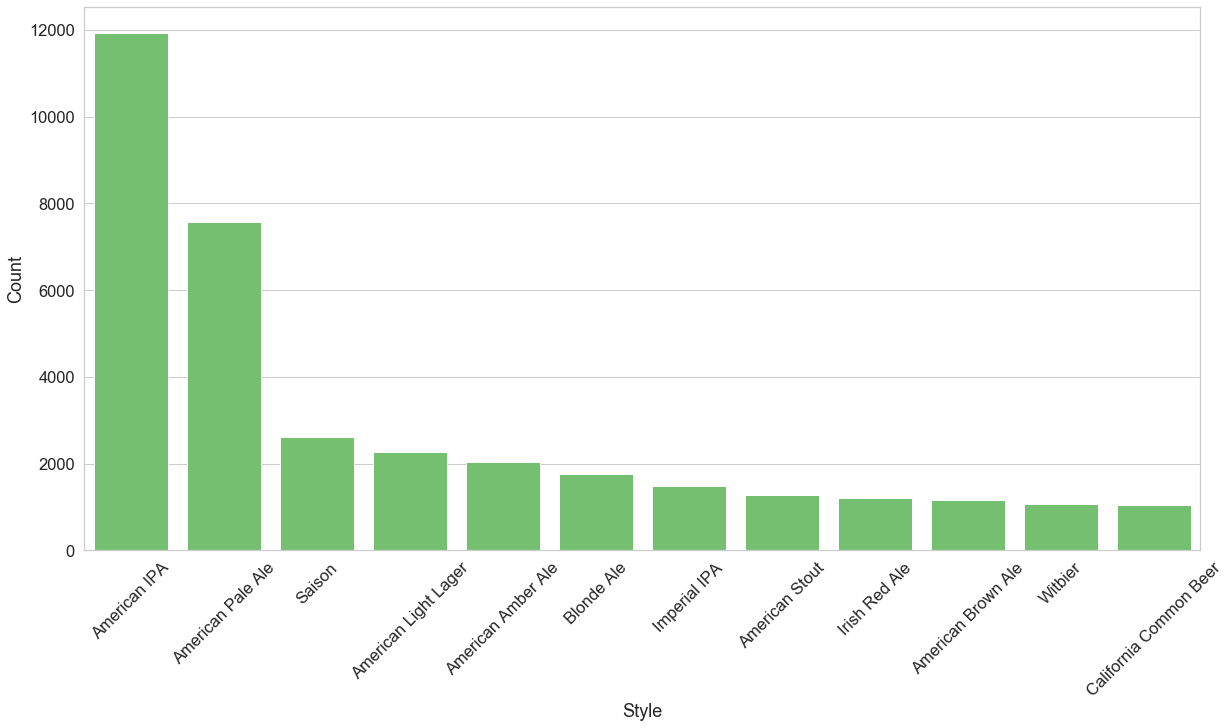

In [9]:
#style distribution
plt.figure(figsize=[20,10])
sns.barplot(x=style_counts.index, y=style_counts.Style, color='g')
plt.xticks(rotation=45)
plt.xlabel('Style')
plt.ylabel('Count')

In [10]:
beer_classes = sorted(list(style_counts.index))
print(beer_classes)
print(len(beer_classes))

['American Amber Ale', 'American Brown Ale', 'American IPA', 'American Light Lager', 'American Pale Ale', 'American Stout', 'Blonde Ale', 'California Common Beer', 'Imperial IPA', 'Irish Red Ale', 'Saison', 'Witbier']
12


These are the 12 most common beers in the dataset. They all contain at least 1000 instances. We will focus on these for our model. As you can see there is some class imbalance. We will see how the model performs and if needed, explore upsampling/downsampling.

In [11]:
#Create dataset that only contains the 12 beer styles
df_beer = df_beer[df_beer.Style.isin(beer_classes)]
df_beer.head()

,Style,StyleID,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
2,American IPA,7,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN
3,American IPA,7,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
5,American Pale Ale,10,1.055,1.013,5.58,40.12,8.00,29.34,70,1.047,79.0,NaN,Specific Gravity,All Grain,1.0,NaN,NaN,NaN
6,Imperial IPA,86,1.072,1.018,7.09,268.71,6.33,30.28,90,NaN,75.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
9,Imperial IPA,86,1.080,1.017,8.22,93.02,8.29,28.39,60,1.058,70.0,NaN,Specific Gravity,All Grain,NaN,21.11,Corn Sugar,4.6 oz / .66 C


In [12]:
df_beer.shape

(35424, 18)

Our dataset of 12 classes containts 35,424 rows.

In [13]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35424 entries, 2 to 73860
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Style          35424 non-null  object 
 1   StyleID        35424 non-null  int64  
 2   OG             35424 non-null  float64
 3   FG             35424 non-null  float64
 4   ABV            35424 non-null  float64
 5   IBU            35424 non-null  float64
 6   Color          35424 non-null  float64
 7   BoilSize       35424 non-null  float64
 8   BoilTime       35424 non-null  int64  
 9   BoilGravity    34124 non-null  float64
 10  Efficiency     35424 non-null  float64
 11  MashThickness  20929 non-null  float64
 12  SugarScale     35424 non-null  object 
 13  BrewMethod     35424 non-null  object 
 14  PitchRate      15875 non-null  float64
 15  PrimaryTemp    24159 non-null  float64
 16  PrimingMethod  2890 non-null   object 
 17  PrimingAmount  2055 non-null   object 
dtypes: flo

'BoilGravity', 'MashThickness', PitchRate' and 'PrimaryTemp' all contain missing values.

In [14]:
#missing value percentage
miss_value_pct = ((df_beer.shape[0] - df_beer.count()) / df_beer.shape[0]) * 100
miss_value_pct

Style             0.000000
StyleID           0.000000
OG                0.000000
FG                0.000000
ABV               0.000000
IBU               0.000000
Color             0.000000
BoilSize          0.000000
BoilTime          0.000000
BoilGravity       3.669828
Efficiency        0.000000
MashThickness    40.918586
SugarScale        0.000000
BrewMethod        0.000000
PitchRate        55.185750
PrimaryTemp      31.800474
PrimingMethod    91.841689
PrimingAmount    94.198848
dtype: float64

'PrimingMethod', 'PrimingAmount' and 'PitchRate' will be dropped as they are missing a significant amount of values. We will attempt to impute 'BoilGravity', 'MashThickness' and 'PrimaryTemp' effectively.

In [15]:
df_beer = df_beer.drop(['PitchRate', 'PrimingMethod', 'PrimingAmount'], axis=1)

In [16]:
#Impute missing values
#look at statistics of columns
nan_columns = df_beer[['BoilGravity', 'MashThickness', 'PrimaryTemp']]
nan_columns.describe()

,BoilGravity,MashThickness,PrimaryTemp
count,34124.000000,20929.000000,24159.000000
mean,1.317733,2.123185,19.750102
std,1.765424,1.676618,3.606455
min,0.000000,0.000000,-17.780000
25%,1.040000,1.500000,18.330000
50%,1.047000,1.500000,20.000000
75%,1.057000,3.000000,21.000000
max,38.400000,63.000000,85.000000


In [17]:
#Impute missing values with average of colum by class
df_beer['BoilGravity'] = df_beer['BoilGravity'].fillna(df_beer.groupby(['StyleID'])['BoilGravity'].transform('mean'))
df_beer['MashThickness'] = df_beer['MashThickness'].fillna(df_beer.groupby(['StyleID'])['MashThickness'].transform('mean'))
df_beer['PrimaryTemp'] = df_beer['PrimaryTemp'].fillna(df_beer.groupby(['StyleID'])['PrimaryTemp'].transform('mean'))

In [18]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35424 entries, 2 to 73860
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Style          35424 non-null  object 
 1   StyleID        35424 non-null  int64  
 2   OG             35424 non-null  float64
 3   FG             35424 non-null  float64
 4   ABV            35424 non-null  float64
 5   IBU            35424 non-null  float64
 6   Color          35424 non-null  float64
 7   BoilSize       35424 non-null  float64
 8   BoilTime       35424 non-null  int64  
 9   BoilGravity    35424 non-null  float64
 10  Efficiency     35424 non-null  float64
 11  MashThickness  35424 non-null  float64
 12  SugarScale     35424 non-null  object 
 13  BrewMethod     35424 non-null  object 
 14  PrimaryTemp    35424 non-null  float64
dtypes: float64(10), int64(2), object(3)
memory usage: 4.3+ MB


In [19]:
#Convert categorical data
from sklearn.preprocessing import LabelEncoder

categorical_mask = (df_beer.dtypes == object)

categorical_columns = df_beer.columns[categorical_mask].to_list()

print(df_beer[categorical_columns].head())

#label encoder
le = LabelEncoder()

#apply label encoder to categorical columns
df_beer[categorical_columns] = df_beer[categorical_columns].apply(lambda x: le.fit_transform(x))

print(df_beer[categorical_columns].head())

               Style        SugarScale BrewMethod
2       American IPA  Specific Gravity    extract
3       American IPA  Specific Gravity  All Grain
5  American Pale Ale  Specific Gravity  All Grain
6       Imperial IPA  Specific Gravity  All Grain
9       Imperial IPA  Specific Gravity  All Grain
   Style  SugarScale  BrewMethod
2      2           1           3
3      2           1           0
5      4           1           0
6      8           1           0
9      8           1           0


In [20]:
df_beer.head()

,Style,StyleID,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PrimaryTemp
2,2,7,1.063,1.018,5.91,59.25,8.98,22.71,60,1.333812,70.0,2.044977,1,3,19.574913
3,2,7,1.061,1.017,5.80,54.48,8.50,26.50,60,1.333812,70.0,2.044977,1,0,19.574913
5,4,10,1.055,1.013,5.58,40.12,8.00,29.34,70,1.047000,79.0,2.302828,1,0,19.504493
6,8,86,1.072,1.018,7.09,268.71,6.33,30.28,90,1.458295,75.0,1.828871,1,0,19.611153
9,8,86,1.080,1.017,8.22,93.02,8.29,28.39,60,1.058000,70.0,1.828871,1,0,21.110000


In [21]:
df_beer = df_beer.drop('StyleID', axis=1)
df_beer.head()

,Style,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PrimaryTemp
2,2,1.063,1.018,5.91,59.25,8.98,22.71,60,1.333812,70.0,2.044977,1,3,19.574913
3,2,1.061,1.017,5.80,54.48,8.50,26.50,60,1.333812,70.0,2.044977,1,0,19.574913
5,4,1.055,1.013,5.58,40.12,8.00,29.34,70,1.047000,79.0,2.302828,1,0,19.504493
6,8,1.072,1.018,7.09,268.71,6.33,30.28,90,1.458295,75.0,1.828871,1,0,19.611153
9,8,1.080,1.017,8.22,93.02,8.29,28.39,60,1.058000,70.0,1.828871,1,0,21.110000


In [22]:
df_beer.describe()

,Style,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PrimaryTemp
count,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000,35424.000000
mean,4.149023,1.363423,1.065177,6.003441,51.925255,10.194425,51.200382,63.679172,1.317788,65.997571,2.122546,0.976880,0.628331,19.714478
std,2.960134,2.016912,0.366010,1.468222,44.433021,8.687101,197.498246,12.106075,1.732762,14.174161,1.291660,0.150286,1.034135,3.015229
min,0.000000,1.000000,0.598715,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.780000
25%,2.000000,1.051000,1.011000,5.180000,28.260000,5.250000,21.000000,60.000000,1.041000,65.000000,1.500000,1.000000,0.000000,18.890000
50%,4.000000,1.058000,1.013000,5.870000,43.005000,7.310000,28.000000,60.000000,1.048000,70.000000,2.044977,1.000000,0.000000,19.574913
75%,6.000000,1.066000,1.016000,6.680000,65.570000,11.230000,30.000000,60.000000,1.059000,75.000000,2.302828,1.000000,1.000000,20.000000
max,11.000000,23.445000,7.745770,54.720000,2197.070000,108.650000,6454.130000,240.000000,38.400000,100.000000,63.000000,1.000000,3.000000,85.000000


It can be seen in the summary statistics table that we have outliers in multiple columns. We will try and handle those now. 

In [23]:
#function to found outliers in column where outlier denoted by z-score > 3
def find_outliers(col):
    z = np.abs(stats.zscore(col))
    idx_outliers = np.where(z > 3, True, False)
    return pd.Series(idx_outliers, index=col.index)

In [24]:
df_outliers = pd.DataFrame()
for col in df_beer.columns:
    df_outliers[col] = find_outliers(df_beer[col])

df_outliers.head()

,Style,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PrimaryTemp
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,True,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [25]:
idx_outlier = df_outliers.apply(lambda x : np.any(x), axis=1)

In [26]:
df_beer = df_beer.loc[idx_outlier == False]
df_beer.head()

,Style,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PrimaryTemp
2,2,1.063,1.018,5.91,59.25,8.98,22.71,60,1.333812,70.0,2.044977,1,3,19.574913
3,2,1.061,1.017,5.80,54.48,8.50,26.50,60,1.333812,70.0,2.044977,1,0,19.574913
5,4,1.055,1.013,5.58,40.12,8.00,29.34,70,1.047000,79.0,2.302828,1,0,19.504493
9,8,1.080,1.017,8.22,93.02,8.29,28.39,60,1.058000,70.0,1.828871,1,0,21.110000
10,2,1.064,1.014,6.63,64.26,7.78,29.00,90,1.055000,74.0,2.044977,1,0,18.000000


In [27]:
df_beer.describe()

,Style,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PrimaryTemp
count,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.000000,31422.0,31422.000000,31422.000000
mean,4.104290,1.058345,1.013124,5.939311,49.216847,9.032452,32.509256,63.610018,1.061444,66.058083,2.064288,1.0,0.630991,19.680085
std,2.996052,0.011281,0.003936,1.162582,30.932354,5.955806,43.885933,10.575745,0.055344,13.769296,0.654995,0.0,1.029472,1.693379
min,0.000000,1.004000,0.999000,1.600000,0.000000,0.000000,1.000000,30.000000,1.000000,23.500000,0.130000,1.0,0.000000,11.000000
25%,2.000000,1.051000,1.010000,5.170000,28.330000,5.230000,21.000000,60.000000,1.040000,65.000000,1.500000,1.0,0.000000,18.890000
50%,3.000000,1.057000,1.013000,5.830000,42.730000,7.180000,27.440000,60.000000,1.047000,70.000000,2.044977,1.0,0.000000,19.574913
75%,6.000000,1.065000,1.015000,6.610000,64.910000,10.650000,29.500000,60.000000,1.057000,75.000000,2.302828,1.0,1.000000,20.000000
max,11.000000,1.167000,1.109000,10.400000,185.220000,36.230000,643.520000,99.000000,1.500000,100.000000,5.900000,1.0,3.000000,28.330000


## 3. Machine Learning

Decision Tree models do not require feature scaling so we will go ahead and build the model.

In [28]:
#Create features and target
X = df_beer.drop('Style', axis=1)
y = df_beer.Style

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [30]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'stratified', 'uniform']

test_scores = []

for s in strategies:
    dclf = DummyClassifier(strategy=s, random_state=0)
    
    dclf.fit(X_train, y_train)
    score = dclf.score(X_test, y_test)
    test_scores.append(score)

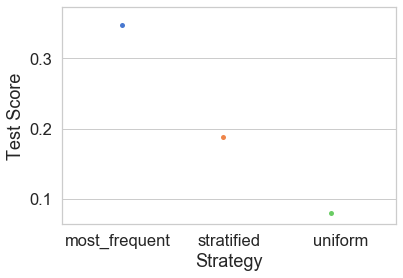

In [31]:
ax = sns.stripplot(strategies, test_scores)
ax.set(xlabel='Strategy', ylabel='Test Score')
plt.show()

In [32]:
xg_cl = xgb.XGBClassifier(objective='multi:softmax', num_class=12, n_estimators=10, seed=123)

In [33]:
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_class=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
#initial model performance
preds = xg_cl.predict(X_test)

accuracy = float(np.sum(preds==y_test)) / len(y_test)
print('accuracy: %f' % (accuracy))

accuracy: 0.842323


In [35]:
preds_train = xg_cl.predict(X_train)
acc_train = float(np.sum(preds_train == y_train)) / len(y_train)
print('accuracy: %f' % (acc_train))

accuracy: 0.868202


Our model not only does much better than a Dummy Classifier but it appears to have slight overfitting but overall a strong generalization. We will now explore performance further.

In [36]:
#cross validation
from sklearn.model_selection import cross_val_score

scores_xgb = cross_val_score(xg_cl, X, y, cv=5, scoring='accuracy')
print(scores_xgb)
print(round(scores_xgb.mean(),3))

[0.87064439 0.84470963 0.84134309 0.83004456 0.82479313]
0.842


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds, target_names=beer_classes))

                        precision    recall  f1-score   support

    American Amber Ale       0.80      0.75      0.77       386
    American Brown Ale       0.83      0.83      0.83       212
          American IPA       0.86      0.92      0.89      2190
  American Light Lager       0.99      0.79      0.88       360
     American Pale Ale       0.83      0.85      0.84      1422
        American Stout       0.73      0.81      0.77        75
            Blonde Ale       0.77      0.76      0.77       327
California Common Beer       0.99      0.73      0.84       181
          Imperial IPA       0.84      0.74      0.79       230
         Irish Red Ale       0.79      0.78      0.78       227
                Saison       0.83      0.82      0.82       474
               Witbier       0.82      0.77      0.79       201

              accuracy                           0.84      6285
             macro avg       0.84      0.79      0.81      6285
          weighted avg       0.84     

[0.08512505 0.01920027 0.07194652 0.17176016 0.12773298 0.00736138
 0.01318629 0.01552598 0.00877505 0.24044786 0.         0.05429006
 0.18464844]


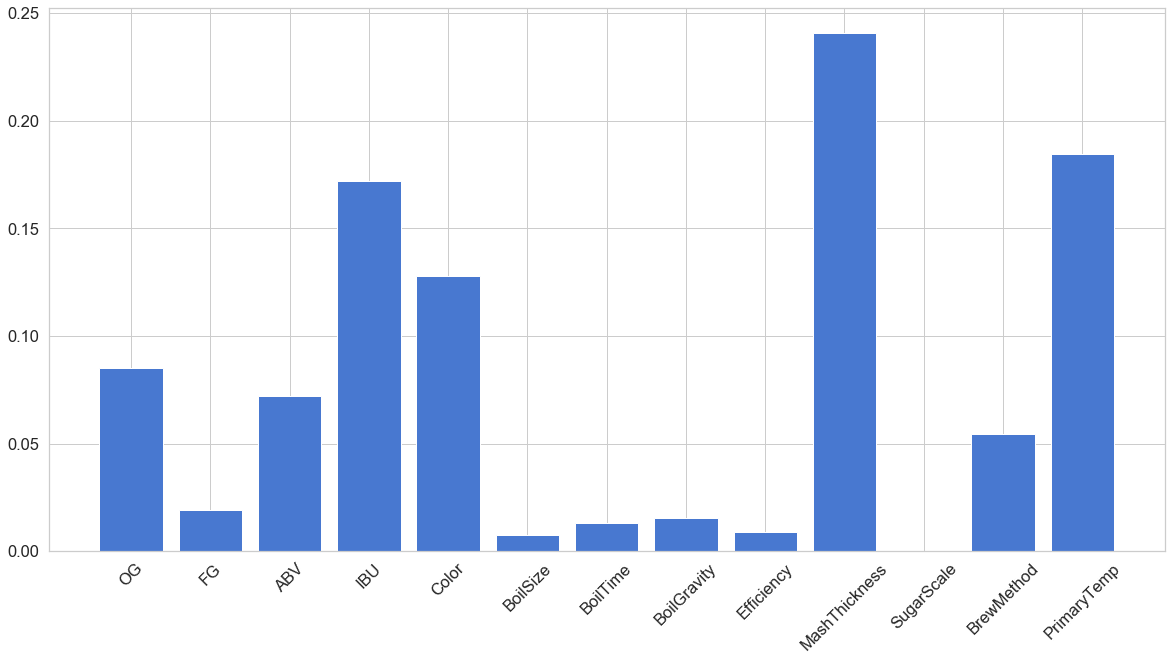

In [38]:
#Feature Importance
print(xg_cl.feature_importances_)
# plot
plt.figure(figsize=[20,10])
plt.bar(X.columns, xg_cl.feature_importances_)
plt.xticks(rotation=45)
plt.show()

The breakdown of each classes precision, recall and f1-score shows how the model performs on each class individually.

This project was mainly focused on implementing XGBoost. It is nice to see that it performs well in predicting beer classes.